In [22]:
%matplotlib inline

import os
import json
import matplotlib
import numpy as np
import scipy as sc
import pandas as pd

In [17]:
epsList = ['0', '0.1', '0.2', '0.5', '1', '2', '4']
# TODO: CHANGE THIS AS WE ANALYZE MORE SAMPLES
numSamples = 10
correctList = []

df = pd.DataFrame(index=[str(i) for i in range(numSamples)])
for eps in epsList:
    jsonPath = "results/sample%d/pca_eps_%s_600_amortized.json" % (numSamples, eps)
    dfNew = pd.read_json(path_or_buf=jsonPath, orient='columns')
    df = df.join(other=dfNew, how='right')
    
    # Add a column to indicate which samples were classified correctly
    prefix = 'Eps %s' % eps
    colList = ['Adv%d %s Classification' % (i, prefix) for i in range(9)]
    df['%s Correct Classification' % prefix] = 45 - df[colList].sum(axis=1)
    df['%s Correct' % prefix] = (df['%s Correct Classification' % prefix] == df['Valid %s Classification' % prefix])
    correctList.append('%s Correct' % prefix)
df[correctList]

,Eps 0 Correct,Eps 0.1 Correct,Eps 0.2 Correct,Eps 0.5 Correct,Eps 1 Correct,Eps 2 Correct,Eps 4 Correct
0,True,False,False,True,True,True,True
1,False,False,False,False,False,False,False
2,True,True,False,True,True,True,True
3,True,False,True,True,True,True,True
4,False,False,False,False,True,True,True
5,True,True,False,True,True,True,True
6,True,False,False,False,True,True,True
7,False,False,True,False,False,False,False
8,False,False,False,False,False,False,False
9,False,True,True,True,False,False,False


In [18]:
dfDict = {}
zeroCorrect = "Eps 0 Correct"
for eps in epsList:
    if eps is '0':
        continue
        
    epsCorrect = "Eps %s Correct" % eps
    dfDict[eps] = df[df[zeroCorrect] & df[epsCorrect]]

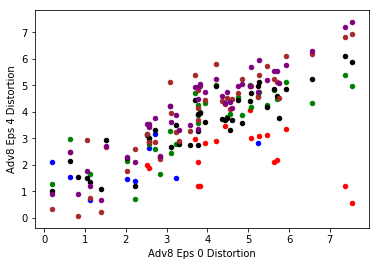

In [19]:
ax = None
colorMap = {'0.1': 'red', '0.2': 'blue', '0.5': 'green', '1': 'black', '2': 'brown', '4': 'purple'}

for eps in dfDict:  
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        if ax is None:
            ax = dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps])
        else:
            dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps], ax=ax)

In [26]:
linregDict = {}
for eps in dfDict:
    x = []
    y = []
    for i in range(9):
        xLabel = "Adv%d Eps 0 Distortion" % i
        yLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        x.extend(dfDict[eps][xLabel].values)
        y.extend(dfDict[eps][yLabel].values)
        
    reg = sc.stats.linregress(x, y)
    linregDict[eps] = reg[0]
linregDict

{'0.1': -0.09192473445195318,
 '0.2': 0.2576521708865428,
 '0.5': 0.575616968851832,
 '1': 0.6476521075037904,
 '2': 0.8447706985947195,
 '4': 0.8496869695452668}